In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/# DS Capstone/4 Transformers

/content/drive/MyDrive/# DS Capstone/4 Transformers


In [3]:
#from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
from matplotlib import pyplot
from math import sqrt
pyplot.style.use('seaborn')
from datetime import datetime
#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

<ipython-input-3-ce30d120408c>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  pyplot.style.use('seaborn')


In [5]:
# Load file

file_path = './data_20y.xlsx'
dataset = pd.read_excel(file_path, header=0, index_col=False)
dataset.drop(dataset.tail(1).index,inplace=True)

dataset['date'] = pd.to_datetime(dataset['date'])
specific_date = pd.to_datetime('2016-01-01')
dataset = dataset[dataset['date'] >= specific_date]

print(dataset.head())

           date  shci_20y    sp_20y   nas_20y   vix_20y    rf_20y  \
2956 2016-01-04 -0.068637 -0.015304 -0.020833  0.136738 -0.010577   
2957 2016-01-05 -0.002594  0.002012 -0.002378 -0.065701  0.001336   
2958 2016-01-06  0.022548 -0.013115 -0.011381  0.064633 -0.031584   
2959 2016-01-07 -0.070450 -0.023700 -0.030260  0.213696 -0.011024   
2960 2016-01-08  0.019651 -0.010838 -0.009767  0.080832 -0.010683   

      forward_shci_20y  
2956         -0.002594  
2957          0.022548  
2958         -0.070450  
2959          0.019651  
2960         -0.053261  


In [6]:
dataset.drop(dataset.columns[0], axis=1, inplace=True)
values = dataset.values
print(dataset.head())
print(dataset.tail())

      shci_20y    sp_20y   nas_20y   vix_20y    rf_20y  forward_shci_20y
2956 -0.068637 -0.015304 -0.020833  0.136738 -0.010577         -0.002594
2957 -0.002594  0.002012 -0.002378 -0.065701  0.001336          0.022548
2958  0.022548 -0.013115 -0.011381  0.064633 -0.031584         -0.070450
2959 -0.070450 -0.023700 -0.030260  0.213696 -0.011024          0.019651
2960  0.019651 -0.010838 -0.009767  0.080832 -0.010683         -0.053261
      shci_20y    sp_20y   nas_20y   vix_20y    rf_20y  forward_shci_20y
4690 -0.015238 -0.011222 -0.012620  0.076700 -0.005647         -0.012781
4691 -0.012781 -0.007319 -0.006058  0.080950  0.005679         -0.001089
4692 -0.001089  0.008758  0.017136 -0.044433  0.025544          0.003511
4693  0.003511  0.013049  0.021862 -0.062173 -0.001049          0.000857
4694  0.000857  0.000017  0.003217 -0.027298 -0.028871         -0.006095


In [7]:
# Split into train, val, test sets 8:1:1
n_train = int(len(dataset) * 0.9)
train = values[:n_train, :]
test = values[n_train:, :]

# n_val = int(len(val_test) * 0.5)
# val = val_test[:n_val, :]
# test = val_test[n_val:, :]

# Print the shapes of train, val, and test sets
print("Dataset shape:", dataset.shape)
print("Train set shape:", train.shape)
# print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)

Dataset shape: (1739, 6)
Train set shape: (1565, 6)
Test set shape: (174, 6)


In [8]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
# scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [9]:
# Split into input and outputs
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
# val_X, val_y = scaled_val[:, :-1], scaled_val[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]

print("train_X", train_X.shape)
print("train_y", train_y.shape)
# print("val_X", val_X.shape)
# print("val_y", val_y.shape)
print("test_X", test_X.shape)
print("test_y", test_y.shape)

train_X (1565, 5)
train_y (1565,)
test_X (174, 5)
test_y (174,)


In [10]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [13]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [14]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [15]:
input_shape = train_X.shape[1:]
print(input_shape)

(1, 5)


In [16]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.1,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    train_X,
    train_y,
    validation_split=1/9,
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
)
#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()
#pyplot.show()

Epoch 1/50
11/11 [==============================] - 22s 265ms/step - loss: 0.3064 - mean_squared_error: 0.3064 - val_loss: 0.3131 - val_mean_squared_error: 0.3131 - lr: 1.0000e-06
Epoch 2/50
11/11 [==============================] - 2s 183ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.0653 - val_mean_squared_error: 0.0653 - lr: 3.4300e-05
Epoch 3/50
11/11 [==============================] - 3s 306ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - lr: 6.7600e-05
Epoch 4/50
11/11 [==============================] - 4s 351ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - lr: 1.0090e-04
Epoch 5/50
11/11 [==============================] - 3s 239ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - lr: 1.3420e-04
Epoch 6/50
11/11 [==============================] - 2s 190ms/step - loss: 0.0241 - mean_squared_error: 0

In [17]:
# Evaluate the model and calculate Train RMSE
train_yhat = model.predict(train_X)
train_yhat_copies_array = np.repeat(train_yhat, 6, axis=-1)
inv_train_yhat = scaler.inverse_transform(np.reshape(train_yhat_copies_array, (len(train_yhat), 6)))[:, 0]
train_original_copies_array = np.repeat(train_y, 6, axis=-1)
inv_train_y = scaler.inverse_transform(np.reshape(train_original_copies_array, (len(train_y), 6)))[:, 0]
train_rmse = sqrt(mean_squared_error(inv_train_yhat, inv_train_y))
print('Train RMSE: %.4f' % train_rmse)

49/49 [==============================] - 2s 20ms/step
Train RMSE: 0.0112


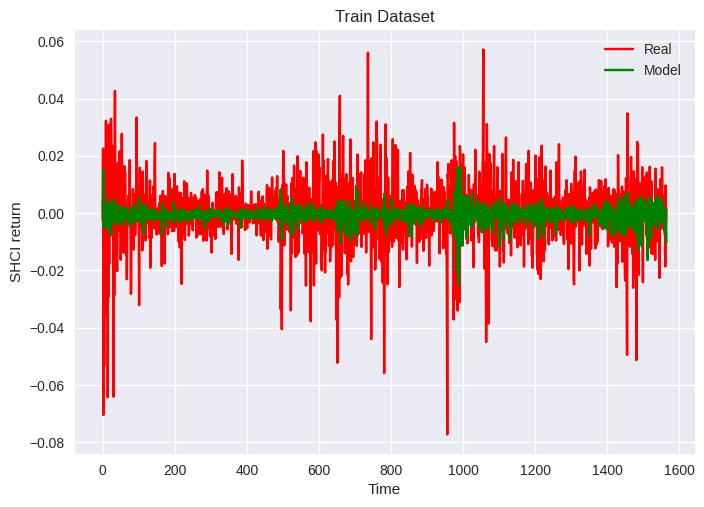

In [18]:
# Plot and check train set
pyplot.plot(inv_train_y, color='red', label='Real')
pyplot.plot(inv_train_yhat, color='green', label='Model')
pyplot.title('Train Dataset')
pyplot.xlabel('Time')
pyplot.ylabel('SHCI return')
pyplot.legend()
pyplot.show()

In [19]:
# Make predictions
yhat = model.predict(test_X)
yhat_copies_array = np.repeat(yhat, 6, axis = -1)
inv_yhat = scaler.inverse_transform(np.reshape(yhat_copies_array, (len(yhat), 6)))[:, 0]
original_copies_array = np.repeat(test_y, 6, axis=-1)
inv_y = scaler.inverse_transform(np.reshape(original_copies_array, (len(test_y), 6)))[:, 0]
rmse = sqrt(mean_squared_error(inv_yhat, inv_y))
print('Test RMSE: %.4f' % rmse)

6/6 [==============================] - 0s 17ms/step
Test RMSE: 0.0086


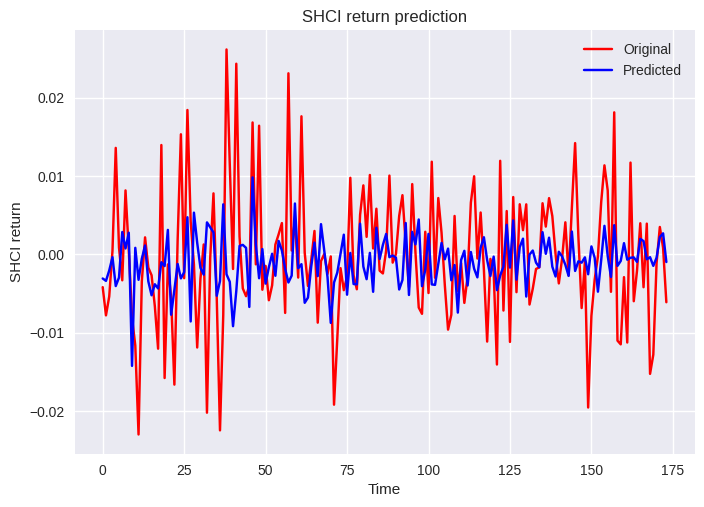

In [20]:
# plot predicted vs actual
pyplot.plot(inv_y, color='red', label='Original')
pyplot.plot(inv_yhat, color='blue', label='Predicted')
pyplot.title('SHCI return prediction')
pyplot.xlabel('Time')
pyplot.ylabel('SHCI return')
pyplot.legend()
pyplot.show()